# Project Report

## Navigating Germany's Rental Landscape for International Students

### Summary

<p> The project aims to analyze data concerning international students and rental properties in bayren, Germany. By examining this information, the project seeks to provide valuable insights to newcomers, helping them identify cities in bayren, Germany with the most favorable accommodation options and thus facilitating their transition to the country.</p>

### Project Flow

1. Data Acquisition:
- Obtain information about rental property listings from Immoscout24 from the provided metadata URL and download the corresponding csv file.
- Obtain the Foreign students dataset from the provided metadata URL and download the corresponding xlsx file.

Datasource1: Foreign students in Germany
- Metadata URL: https://data.europa.eu/data/datasets/https-www-datenportal-bmbf-de-portal-2-5-34
- Data URL: https://www.datenportal.bmbf.de/portal/Tabelle-2.5.34.xls
- Data Type: xlsx

This dataset comprises information about international students admitted to degree programs in  bayren Germany over a specific time period. It includes data on the students' nationalities, degree programs, admission dates, and other relevant attributes.

Datasource2: Immoscout24 dataset
- Metadata URL: https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany
- Data URL: https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany/download?datasetVersionNumber=6
- Data Type: xlsx

This dataset comprises information about rental property listings from Immoscout24, which is the largest real estate platform in bayren Germany. It includes details about rental prices, property characteristics, and the property's location.

In [219]:
# Import all necessary libraries
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import folium
import matplotlib.pyplot as plt
from IPython.display import display

# Connect to the database
conn = sqlite3.connect('../dataset.sqlite')  

# Query the database and load data into a DataFrames
immoscout_table = f"SELECT * FROM immoscout"
immoscout_df = pd.read_sql_query(immoscout_table, conn)

intstudents_table = f"SELECT * FROM intstudents"
intstudents_df = pd.read_sql_query(intstudents_table, conn)

# Close the database connection
conn.close()

In [220]:
# List of columns to convert from float64 to int
columns = ['Humanities', 'Social sciences', 'Mathematics',
                 'Engineering sciences', 'Computer Science',
                 'Medicine', 'Agriculture']

# Calculate total students and add a new column
intstudents_df['Total-Student'] = intstudents_df[columns].sum(axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


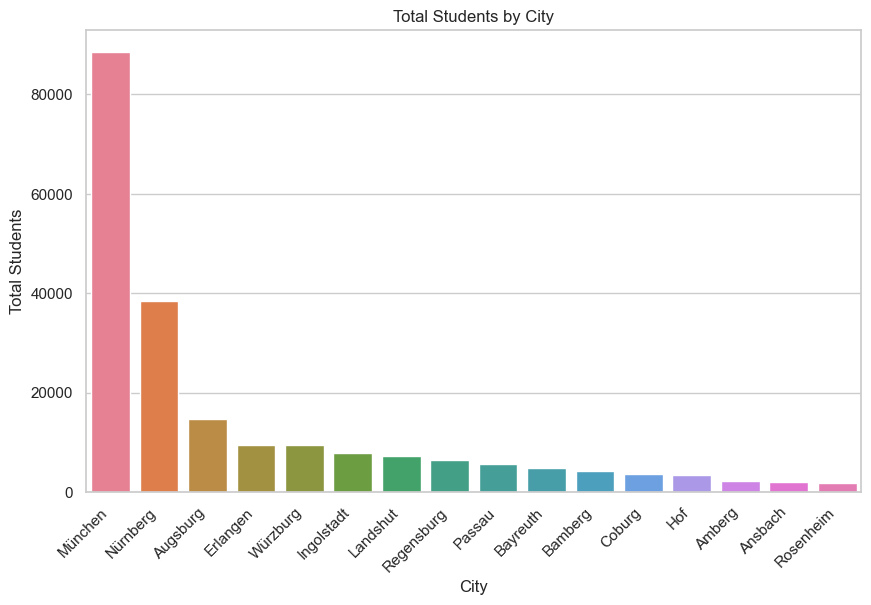

In [221]:
columns_to_use = ['City', 'Total-Student']
df_bar = intstudents_df[columns_to_use].groupby('City').sum()

# Sort the DataFrame by Total-Student in ascending order
df_bar = df_bar.sort_values(by='Total-Student', ascending=False)

# Set a seaborn color palette for different cities
city_palette = sns.color_palette("husl", n_colors=len(df_bar))

# Plot the compound bar graph using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=df_bar.index, y='Total-Student', data=df_bar, palette=city_palette, hue=df_bar.index)

ax.set_xlabel('City')
ax.set_ylabel('Total Students')
ax.set_title('Total Students by City')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Remove the legend, as it's not needed in this case
ax.legend().set_visible(False)

plt.show()



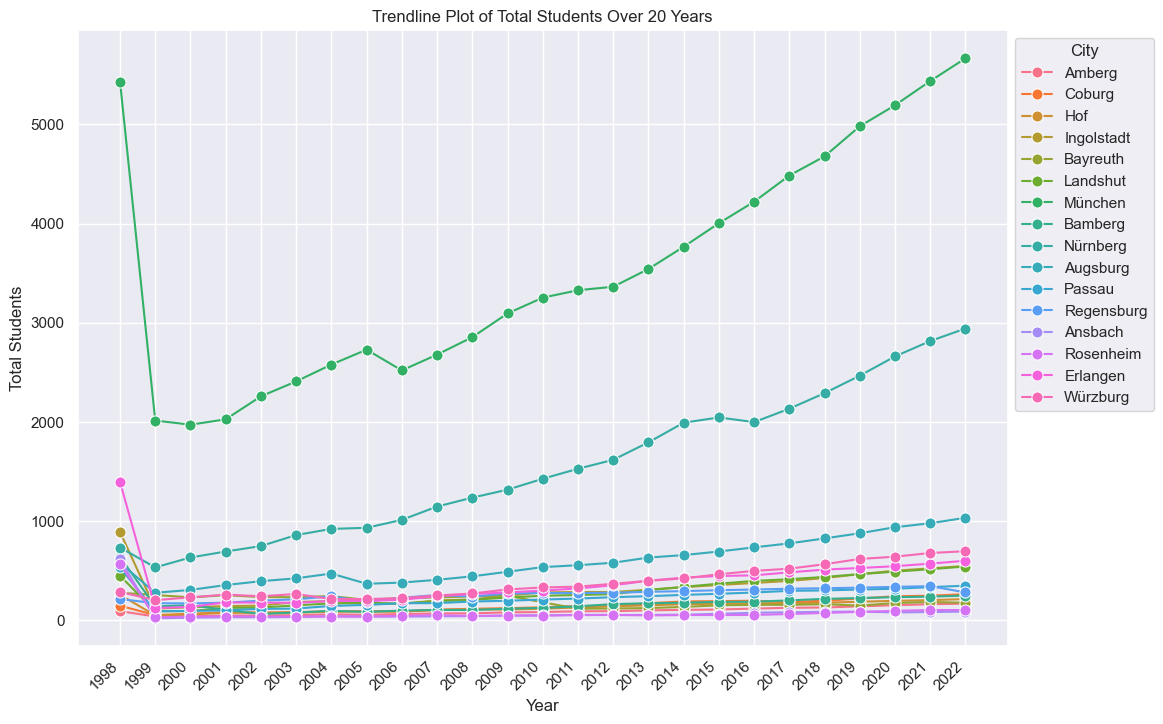

In [222]:
columns_to_use = ['City', 'Year', 'Total-Student']
df_trendline = intstudents_df[columns_to_use].copy()

# Group by 'City' and 'Year', and sum the 'Total-Student' values within each group
df_trendline_grouped = df_trendline.groupby(['City', 'Year'])['Total-Student'].sum().reset_index()

# Sort the DataFrame by 'Year'
df_trendline_grouped = df_trendline_grouped.sort_values(by='Year')

sns.set(style="darkgrid")

# Create a trendline plot
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='Year', y='Total-Student', hue='City', data=df_trendline_grouped, errorbar=None, marker='o', markersize=8)

plt.title('Trendline Plot of Total Students Over 20 Years')
plt.xlabel('Year')
plt.ylabel('Total Students')
plt.legend(title='City', loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.show()


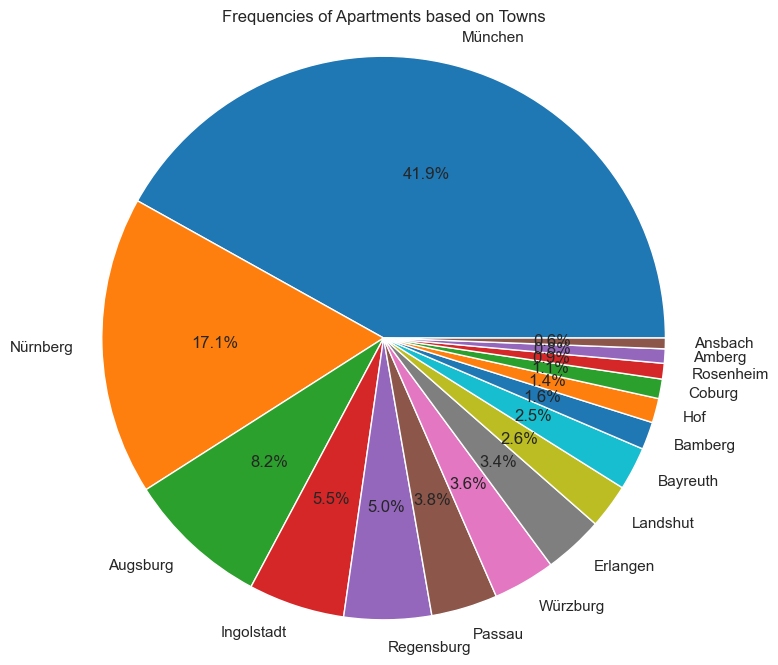

In [223]:
apartments_wrt_town = immoscout_df['City'].value_counts()

# Sort the values for better visualization
apartments_wrt_town_sorted = apartments_wrt_town.sort_values(ascending=False)

# Set a seaborn color palette for different cities
town_palette = sns.color_palette("tab10", n_colors=len(apartments_wrt_town_sorted))

# Plot the pie chart using seaborn
plt.figure(figsize=(8, 8))
plt.pie(apartments_wrt_town_sorted.values, labels=apartments_wrt_town_sorted.index, autopct='%1.1f%%', colors=town_palette)
plt.title('Frequencies of Apartments based on Towns')
plt.axis('equal') 
plt.show()


In [224]:
# Extract data for Munich and Nuremberg
munich_data = immoscout_df[immoscout_df['City'] == 'München'][['latitude', 'longitude']].dropna().values.tolist()
nuremberg_data = immoscout_df[immoscout_df['City'] == 'Nürnberg'][['latitude', 'longitude']].dropna().values.tolist()

In [225]:
# Create a Folium map
map_center = [48.1351, 11.5820]  # Center the map around Munich
munich_map = folium.Map(location=map_center, zoom_start=11)

# Add Circle markers to the map
for location in munich_data:
    folium.Circle(location=location, radius=200, color='blue', fill=True).add_to(munich_map)

# Display the Folium map
display(munich_map)

In [226]:
import os
# Create a Folium map
map_center = [49.4521, 11.0767]  # Center the map around Munich
nurnberg_map = folium.Map(location=map_center, zoom_start=11)

# Add Circle markers to the map
for location in nuremberg_data:
    folium.Circle(location=location, radius=200, color='blue', fill=True).add_to(nurnberg_map)

# Display the Folium map
display(nurnberg_map)

In [227]:
# Filter the DataFrame to include only rows where 'noRooms' is an integer
filtered_df = immoscout_df[immoscout_df['noRooms'].astype(int) == immoscout_df['noRooms']]

# Group by 'district' and calculate the total number of rooms in each district
total_rooms_per_city = filtered_df.groupby('City')['noRooms'].sum().reset_index()

In [228]:
columns_to_use = ['City', 'Total-Student']
# Fetch student data for year 2022
intstudents_df = intstudents_df[intstudents_df['Year'] == '2022']

#groupby data according to Cities
df_bar = intstudents_df[columns_to_use].groupby('City').sum()
df_bar.reset_index(inplace=True)
df_bar.rename(columns={'City': 'City'}, inplace=True)

In [232]:
# Claulate percatage of number of room occupied and available in cities in 2022
df_bar['Total-Student-percentage'] = (df_bar['Total-Student']/total_rooms_per_city['noRooms'])*100

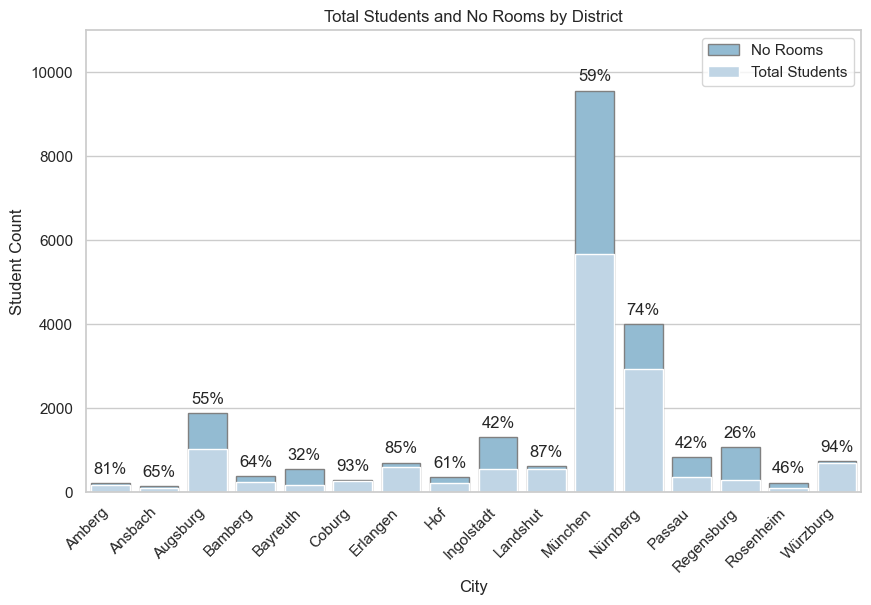

In [231]:
# Set the Seaborn style to 'whitegrid' for a light background
sns.set_style("whitegrid")

# Create a bar plot with visually attractive color scheme
plt.figure(figsize=(10, 6), facecolor='None')  # Set facecolor to 'None' for transparent background

# Define visually attractive colors
total_students_color = sns.color_palette("Blues")[1]  # A shade of blue
no_rooms_color = sns.color_palette("Blues")[2]  # A shade of gray

ax1 = sns.barplot(x='City', y='noRooms', data=total_rooms_per_city, color=no_rooms_color, edgecolor='grey', label='No Rooms')

ax2 = sns.barplot(x='City', y='Total-Student', data=df_bar, color=total_students_color, label='Total Students')

# Annotate each bar with values from the 'annotation_column'
for p, annotation_value in zip(ax1.patches, df_bar['Total-Student-percentage']):
    ax1.annotate(f'{annotation_value:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.xlabel('City')
plt.ylabel('Student Count')
plt.title('Total Students and No Rooms by District')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
# Display the legend
plt.legend()
plt.ylim(0,11000)
# Show the plot
plt.show()
